In [1]:
import os
import json

import numpy as np
import pennylane as qml

In [54]:
folder_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files\AHO"
file_paths = os.listdir(folder_path)

In [55]:
file_paths

['AHO_16.json', 'AHO_32.json', 'AHO_8.json']

In [56]:
for path in file_paths:

    data_path = os.path.join(folder_path,path)
    data_dict = {}

    with open(data_path, 'r') as file:
            data = json.load(file)

    cutoff = data['cutoff']
    potential = data['potential']

    print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

    num_qubits = int(np.log2(cutoff)) + 1
    min_eigenvalue = min(data['exact_eigenvalues'])

    # Only consider data that has converge to min energy
    mask = []
    for d in data['min_energies']:
        if abs(d - min_eigenvalue) < 1e-6:
            mask.append(True)
        else:
            mask.append(False)

    # Clean and prepare circuit data
    d_ops = [op.replace('))',')') for op in data['op_list']]
    min_ops = [op_list for op_list, keep in zip(d_ops, mask) if keep]
    min_ops = [eval(ops, {"RY": qml.RY, "CRX": qml.CRX, "CRY": qml.CRY, "np": np}) for ops in min_ops]

    # Find op list with minimum number of gates
    min_len = min([len(ops) for ops in min_ops])
    reduced = [ops for ops in min_ops if len(ops) == min_len]

    # Take the unique circuits
    unique = []
    for op_list in reduced:
        if op_list not in unique:
            unique.append(op_list)

    data_dict['potential'] = potential
    data_dict['cutoff'] = cutoff
    data_dict['circuits'] = str(unique)

    file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

   
    with open(file_path, "w") as file:
        json.dump(data_dict, file, indent=4)


    # Define the device
    dev = qml.device("default.qubit", wires=num_qubits)
    basis_state = data['basis_state']

    for i in range(len(unique)):
    
        @qml.qnode(dev)
        def circuit():

            qml.BasisState(basis_state, wires=range(num_qubits))

            for op in unique[i]:
                op.queue()
            return qml.state()
        
        circuit_diagram = qml.draw(circuit)()

        with open(file_path, "a", encoding="utf-8") as file:
            file.write("\n###############################\n")
            file.write(circuit_diagram)
            file.write("\n###############################\n")




Finding optimal circuit for AHO - cutoff 16
Finding optimal circuit for AHO - cutoff 32
Finding optimal circuit for AHO - cutoff 8


In [6]:
num_qubits = 6
dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def circuit(params):

    basis = [0]*num_qubits
    qml.BasisState(basis, wires=range(num_qubits))
    
    qml.RY(params[0], wires=[num_qubits-3])
    qml.RY(params[1], wires=[num_qubits-1])
    qml.CRY(params[2], wires=[num_qubits-1, num_qubits-2])
    qml.RY(params[3], wires=[num_qubits-2])
        
    return qml.state()

(<Figure size 700x700 with 1 Axes>, <Axes: >)

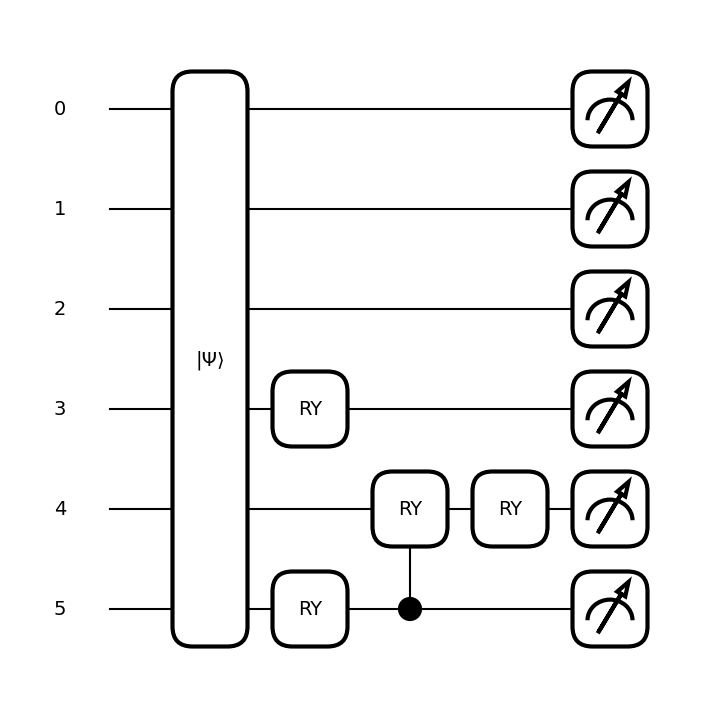

In [7]:
params = np.random.random(size=4)
qml.draw_mpl(circuit)(params)